In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

pitch = pd.read_excel("corrected_pitch.xlsx")
gk = pd.read_excel("corrected_gk.xlsx")

In [32]:
pitch.head()

,Name,Exp_contr,Team_from,Team_to,Transfer_value,Position,Year,Age,Matches_pl,Matches_pl_LS,...,Tackles_won,Interceptions,GCA_BC,GCA_BC_LS,Yellow_cards,Red_cards,Country_from,Country_to,Reduced_from,Reduced_to
0,Aaron Connolly,11,Brighton,Hull City,1350000,Centre-Forward,2023,23,55,11,...,7,5,1,0,4,0,Inglaterra,Inglaterra,Inglaterra,Inglaterra
1,Aaron Hickey,24,Bologna,Brentford,14250000,Left-Back,2022,20,70,36,...,37,44,5,4,16,2,Italia,Inglaterra,Italia,Inglaterra
2,Aaron Hickey,8,Heart of Midl.,Bologna,1700000,Left-Back,2020,18,24,22,...,0,0,0,0,7,1,Escocia,Italia,Otros,Italia
3,Aaron Leya Iseka,10,OFI Crete FC,CSKA-Sofia,1200000,Centre-Forward,2024,26,40,13,...,2,5,0,0,3,0,Grecia,Bulgaria,Otros,Otros
4,Aaron Mooy,34,Brighton,SH Port,4500000,Central Midfield,2020,29,101,33,...,131,76,17,7,11,1,Inglaterra,China,Inglaterra,Otros


In [2]:
def list_reduced(lista, mains):
    new_list = []
    for c in lista:
        if c in mains:
            new_list.append(c)
        else:
            new_list.append("Otros")
    return new_list

mains = ["Inglaterra", "Francia", "España", "Italia", "Alemania", "Portugal", "Países Bajos", "Argentina", "Brasil"]

c_pitch_from_reduced = list_reduced(pitch.Country_from, mains)
c_pitch_to_reduced = list_reduced(pitch.Country_to, mains)

pitch["Reduced_from"] = c_pitch_from_reduced
pitch["Reduced_to"] = c_pitch_to_reduced

c_gk_from_reduced = list_reduced(gk.Country_from, mains)
c_gk_to_reduced = list_reduced(gk.Country_to, mains)

gk["Reduced_from"] = c_gk_from_reduced
gk["Reduced_to"] = c_gk_to_reduced

gk["Save_perc"] = gk.apply(lambda row: round((row['SoTA'] - row['GA'])/row['SoTA'], 2) if row['SoTA'] > 0 else 0, axis=1)
gk["Save_perc_BC"] = gk.apply(lambda row: round((row['SoTA_BC'] - row['GA_BC'])/row['SoTA_BC'], 2) if row['SoTA_BC'] > 0 else 0, axis=1)
gk["Save_perc_LS"] = gk.apply(lambda row: round((row['SoTA_LS'] - row['GA_LS'])/row['SoTA_LS'], 2) if row['SoTA_LS'] > 0 else 0, axis=1)

In [3]:
def dic_count(lista):
    dic = {}
    for c in lista:
        if c in dic:
            dic[c] += 1
        else:
            dic[c] = 1
    return dic

dic_country_from_pitch = dict(sorted(dic_count(c_pitch_from_reduced).items(), key=lambda item: item[1], reverse=True))
dic_country_to_pitch = dict(sorted(dic_count(c_pitch_to_reduced).items(), key=lambda item: item[1], reverse=True))

dic_country_from_gk = dict(sorted(dic_count(c_gk_from_reduced).items(), key=lambda item: item[1], reverse=True))
dic_country_to_gk = dict(sorted(dic_count(c_gk_to_reduced).items(), key=lambda item: item[1], reverse=True))

In [4]:
def dic_spend(*dfs):
    dic_total = {}
    for df in dfs:
        for row in df.itertuples(index=False):
            if row.Reduced_to in dic_total:
                dic_total[row.Reduced_to] += row.Transfer_value
            else:
                dic_total[row.Reduced_to] = row.Transfer_value
    return dic_total

dic_extern_from = {}

for row in extern.itertuples(index=False):  # index=False si no necesitas el índice
    if row.Reduced_from in dic_extern_from:
        dic_extern_from[row.Reduced_from] += row.Transfer_value
    else:
        dic_extern_from[row.Reduced_from] = row.Transfer_value

dic_total = dic_spend(pitch, gk)
dic_intern = dic_spend(pitch[pitch['Country_from'] == pitch['Country_to']], gk[gk['Country_from'] == gk['Country_to']])
dic_extern_to = dic_spend(pitch[pitch['Country_from'] != pitch['Country_to']], gk[gk['Country_from'] != gk['Country_to']])

NameError: name 'extern' is not defined

In [ ]:
dic_total = dict(sorted(dic_total.items(), key=lambda item: item[1], reverse=True))
dic_intern = dict(sorted(dic_intern.items(), key=lambda item: item[1], reverse=True))
dic_extern_from = dict(sorted(dic_extern_from.items(), key=lambda item: item[1], reverse=True))
dic_extern_to = dict(sorted(dic_extern_to.items(), key=lambda item: item[1], reverse=True))

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(dic_total.keys(), dic_total.values())
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))

In [ ]:
dic_dif = {}

for k in dic_extern_from:
    dic_dif[k] = dic_extern_to[k] - dic_extern_from[k]
    
dic_dif = dict(sorted(dic_dif.items(), key=lambda item: item[1], reverse=True))

In [ ]:
plt.figure(figsize=(12, 6))
colores = ['red' if v < 0 else 'blue' for v in dic_dif.values()]
plt.bar(dic_dif.keys(), dic_dif.values(), color = colores)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))

In [6]:
gk.columns

Index(['Name', 'Exp_contr', 'Team_from', 'Team_to', 'Transfer_value',
       'Position', 'Year', 'Age', 'Matches_pl', 'Matches_pl_LS',
       'Matches_pl_BC', 'Matches_pl_BC_LS', 'Starts', 'Starts_LS', 'Starts_BC',
       'Starts_BC_LS', 'Minutes_pl', 'Minutes_pl_LS', 'Minutes_pl_BC',
       'Minutes_pl_BC_LS', 'GA', 'GA_LS', 'GA_BC', 'GA_BC_LS', 'SoTA',
       'SoTA_LS', 'SoTA_BC', 'SoTA_BC_LS', 'CS', 'PKA', 'PKSv', 'Goals',
       'Assists', 'Yellow_cards', 'Red_cards', 'Country_from', 'Country_to',
       'Reduced_from', 'Reduced_to', 'Save_perc', 'Save_perc_BC',
       'Save_perc_LS'],
      dtype='object')

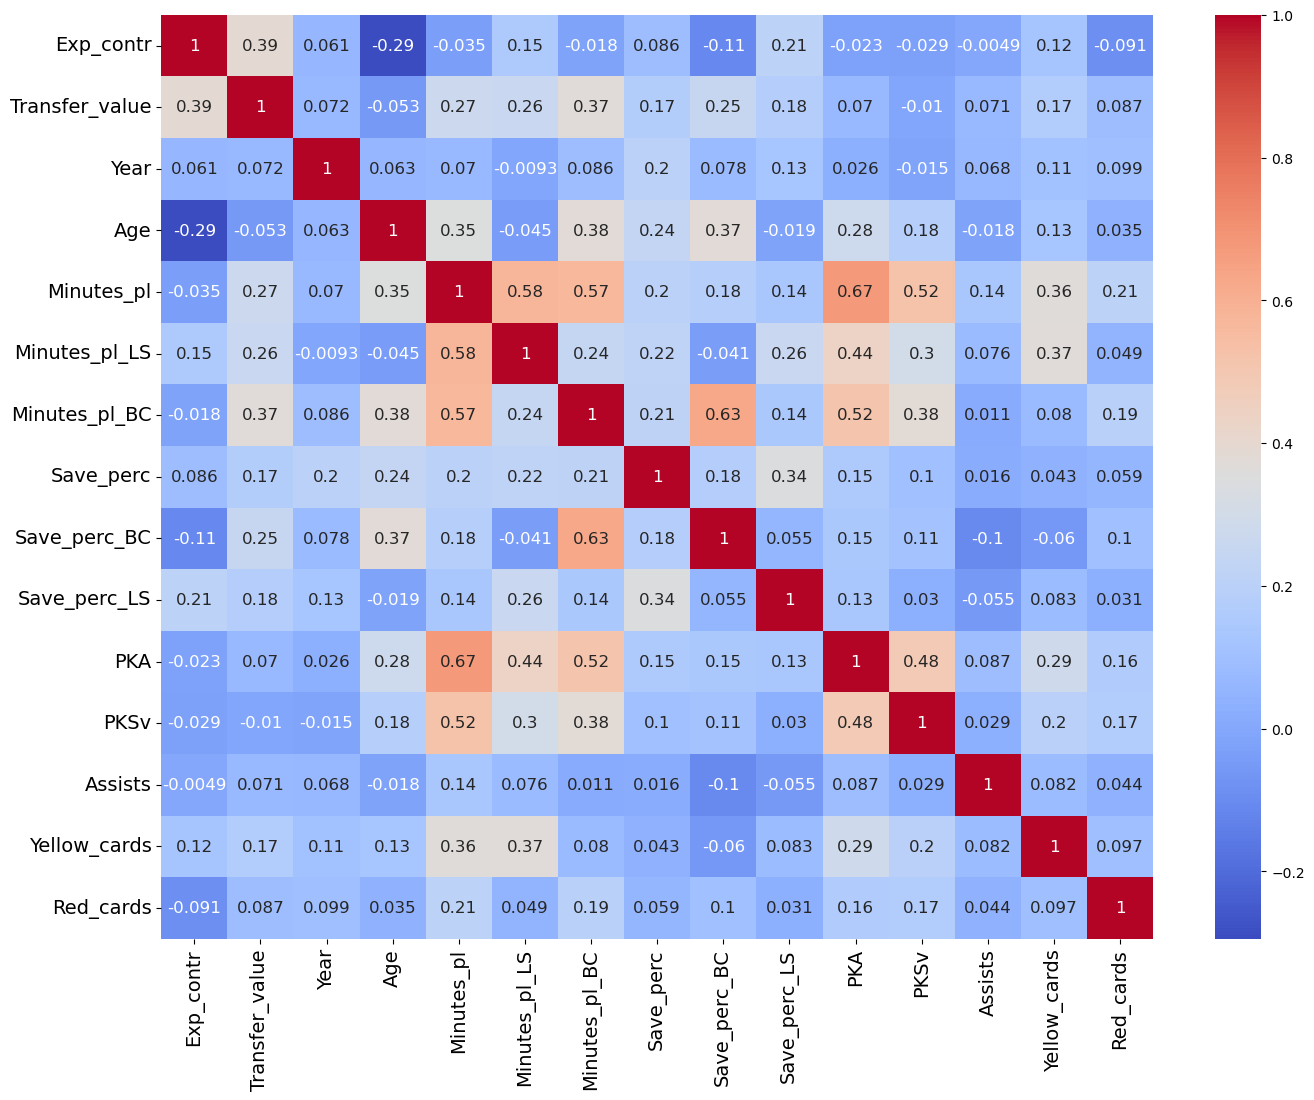

In [5]:
def corr(df, variables):
    df_sub = df[variables]
    plt.figure(figsize=(16, 12))
    sns.heatmap(df_sub.corr(), xticklabels=variables, yticklabels=variables, annot=True, cmap='coolwarm', annot_kws={'size': 12}) #
    plt.xticks(fontsize=14)  # Etiquetas del eje x
    plt.yticks(fontsize=14)


corr(gk, ['Exp_contr', 'Transfer_value',
       'Year', 'Age', 'Minutes_pl', 'Minutes_pl_LS', 'Minutes_pl_BC',
       'Save_perc', 'Save_perc_BC', 'Save_perc_LS', 'PKA', 'PKSv',
       'Assists', 'Yellow_cards', 'Red_cards']);



# ['Matches_pl', 'Starts', 'Minutes_pl', 'Matches_pl_LS', 'Starts_LS', 'Minutes_pl_LS',  
#           'Starts_BC', 'Matches_pl_BC', 'Minutes_pl_BC', 'Matches_pl_BC_LS', 'Starts_BC_LS', 'Minutes_pl_BC_LS']

pitch_vars = ['Exp_contr', 'Transfer_value',
       'Year', 'Age', 'Minutes_pl', 'Minutes_pl_LS', 'Minutes_pl_BC',
       'Save_perc', 'Save_perc_BC', 'Save_perc_LS', 'PKA', 'PKSv',
       'Assists', 'Yellow_cards', 'Red_cards']

gk_vars = ['Exp_contr', 'Transfer_value',
       'Year', 'Age', 'Minutes_pl', 'Minutes_pl_LS', 'Minutes_pl_BC',
       'Save_perc', 'Save_perc_BC', 'Save_perc_LS', 'PKA', 'PKSv',
       'Assists', 'Yellow_cards', 'Red_cards']

In [9]:
gk.to_excel('corrected_gk.xlsx', index = False)

In [52]:
gk.columns

Index(['Name', 'Exp_contr', 'Team_from', 'Team_to', 'Transfer_value',
       'Position', 'Year', 'Age', 'Minutes_pl', 'Minutes_pl_LS',
       'Minutes_pl_BC', 'GA', 'GA_LS', 'GA_BC', 'GA_BC_LS', 'SoTA', 'SoTA_LS',
       'SoTA_BC', 'SoTA_BC_LS', 'CS', 'PKA', 'PKSv', 'Goals', 'Assists',
       'Yellow_cards', 'Red_cards', 'Country_from', 'Country_to', 'Save_perc',
       'Save_perc_BC', 'Save_perc_LS', 'Save_perc_BC_LS'],
      dtype='object')

In [68]:
# pitch.columns

# for n in []:
#     print(n, end = ', ')

Index(['Name', 'Exp_contr', 'Team_from', 'Team_to', 'Transfer_value',
       'Position', 'Year', 'Age', 'Minutes_pl', 'Minutes_pl_LS',
       'Minutes_pl_BC', 'Minutes_pl_BC_LS', 'NP_goals', 'NP_goals_BC',
       'Pen_goals', 'Pen_goals_BC', 'Assists', 'Assists_LS', 'Assists_BC',
       'Assists_BC_LS', 'Shoots', 'Tackles_won', 'Interceptions', 'GCA_BC',
       'GCA_BC_LS', 'Yellow_cards', 'Red_cards', 'Country_from', 'Country_to'],
      dtype='object')

In [66]:
variables = ['Exp_contr', 'Transfer_value',
       'Year', 'Age', 'Minutes_pl', 'Minutes_pl_LS', 'Minutes_pl_BC',
       'Save_perc', 'Save_perc_BC', 'Save_perc_LS', 'PKA', 'PKSv',
       'Assists', 'Yellow_cards', 'Red_cards']

X = gk[variables]

# 'Shoots', 'NP_goals_BC', 'Minutes_pl_LS',

# Añadimos la constante para el modelo (intercepto)
X = add_constant(X)

# Calculamos el VIF para cada variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [round(variance_inflation_factor(X.values, i), 2) for i in range(X.shape[1])]

print(vif_data)

          Variable         VIF
0            const  1418303.68
1        Exp_contr        1.42
2   Transfer_value        1.71
3             Year        1.10
4              Age        1.70
5       Minutes_pl        3.36
6    Minutes_pl_LS        1.99
7    Minutes_pl_BC        3.09
8        Save_perc        1.33
9     Save_perc_BC        2.02
10    Save_perc_LS        1.25
11             PKA        2.19
12            PKSv        1.54
13         Assists        1.06
14    Yellow_cards        1.34
15       Red_cards        1.11


In [1]:
# pitch = pitch.drop(["Starts", "Matches_pl", "Starts_LS", "Matches_pl_LS", "Starts_BC", "Matches_pl_BC", "Starts_BC_LS", "Matches_pl_BC_LS", "Minutes_pl_BC_LS"], axis=1)
# pitch = pitch.drop(['NP_goals_LS', 'NP_goals_BC_LS', 'Pen_goals_LS', 'Pen_goals_BC_LS','Shoots_on_target'], axis = 1)
# pitch = pitch.drop(['Assists_LS', 'Assists_BC', "Assists_BC_LS", "GCA_BC_LS"], axis = 1)
# pitch = pitch.drop(['Shoots', 'NP_goals_BC', 'Minutes_pl_LS', 'Tackles_won'], axis = 1)

# gk = gk.drop(['Matches_pl', 'Matches_pl_LS', 'Matches_pl_BC', 'Matches_pl_BC_LS', 'Starts', 'Starts_LS', 'Starts_BC', 'Starts_BC_LS', 'Minutes_pl_BC_LS'], axis = 1)


NameError: name 'pitch' is not defined

In [88]:
country_colors = {
    'España': 'red',
    'Francia': 'blue',
    'Alemania': 'black',
    'Italia': 'lightgreen',
    'Brasil': 'gold',
    "Inglaterra": "grey",
    "Países Bajos": "orange",
    "Portugal": "green",
    "Argentina": 'lightblue',
    "Otros": "chocolate"
}

In [21]:
pitch.columns

Index(['Name', 'Exp_contr', 'Team_from', 'Team_to', 'Transfer_value',
       'Position', 'Year', 'Age', 'Matches_pl', 'Matches_pl_LS',
       'Matches_pl_BC', 'Matches_pl_BC_LS', 'Starts', 'Starts_LS', 'Starts_BC',
       'Starts_BC_LS', 'Minutes_pl', 'Minutes_pl_LS', 'Minutes_pl_BC',
       'Minutes_pl_BC_LS', 'NP_goals', 'NP_goals_LS', 'NP_goals_BC',
       'NP_goals_BC_LS', 'Pen_goals', 'Pen_goals_LS', 'Pen_goals_BC',
       'Pen_goals_BC_LS', 'Assists', 'Assists_LS', 'Assists_BC',
       'Assists_BC_LS', 'Shoots', 'Shoots_on_target', 'Tackles_won',
       'Interceptions', 'GCA_BC', 'GCA_BC_LS', 'Yellow_cards', 'Red_cards',
       'Country_from', 'Country_to', 'Reduced_from', 'Reduced_to'],
      dtype='object')

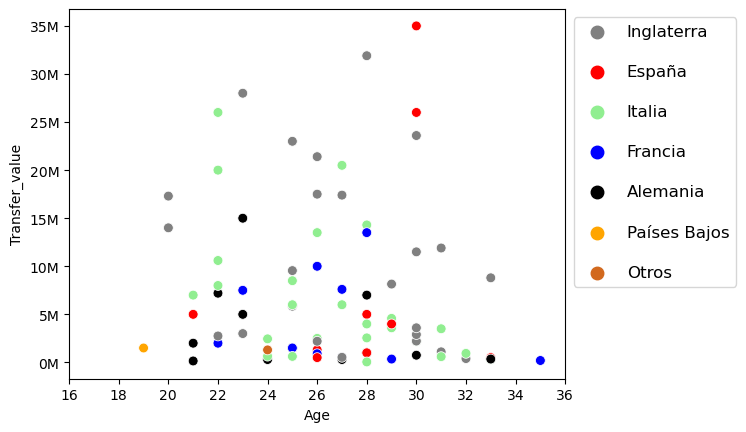

In [89]:
# palette = sns.color_palette("tab10", n_colors=len(pitch['Country_from'].unique()))

sns.scatterplot(data=gk[gk['Country_from'] == gk['Country_to']], 
                x='Age', 
                y='Transfer_value',
                hue='Reduced_from',  # Color según el número de estimadores
#                 style='Reduced_from',  # Forma según el número de componentes PCA
#                 edgecolor=knn_csv['K'].map({pca_value: color for pca_value, color in zip(knn_csv['K'].unique(), palette)}),
                s = 50,
                palette=country_colors)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1),  
               fontsize=12, markerscale=1.5, labelspacing=1.5)

plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))

plt.xticks(range(int(pitch['Age'].min()), int(pitch['Age'].max()) + 2, 2));

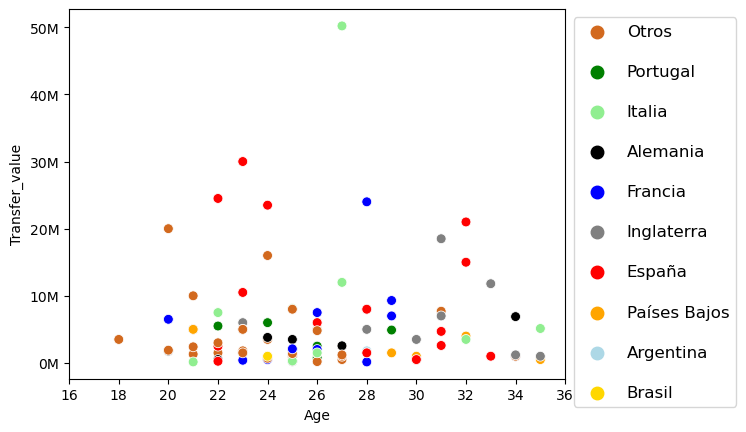

In [90]:
sns.scatterplot(data=gk[gk['Country_from'] != gk['Country_to']], 
                x='Age', 
                y='Transfer_value',
                hue='Reduced_from',  # Color según el número de estimadores
#                 style='Reduced_from',  # Forma según el número de componentes PCA
#                 edgecolor=knn_csv['K'].map({pca_value: color for pca_value, color in zip(knn_csv['K'].unique(), palette)}),
                s = 50,
                palette=country_colors)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1),  
               fontsize=12, markerscale=1.5, labelspacing=1.5)

plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))

plt.xticks(range(int(pitch['Age'].min()), int(pitch['Age'].max()) + 2, 2));

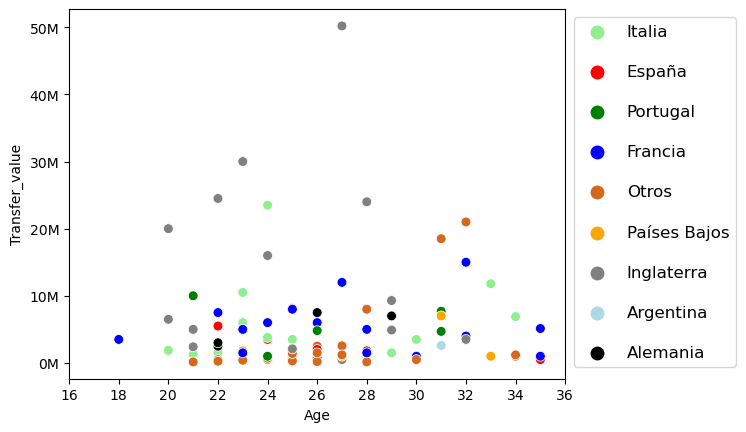

In [91]:
sns.scatterplot(data=gk[gk['Country_from'] != gk['Country_to']], 
                x='Age', 
                y='Transfer_value',
                hue='Reduced_to',  # Color según el número de estimadores
#                 style='Reduced_from',  # Forma según el número de componentes PCA
#                 edgecolor=knn_csv['K'].map({pca_value: color for pca_value, color in zip(knn_csv['K'].unique(), palette)}),
                s = 50,
                palette=country_colors)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1),  
               fontsize=12, markerscale=1.5, labelspacing=1.5)

plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))


plt.xticks(range(int(pitch['Age'].min()), int(pitch['Age'].max()) + 2, 2));

In [22]:
# exp = pitch[pitch['Transfer_value'] > 100000000]
# for row in exp.itertuples(index=False):  # index=False si no necesitas el índice
#     print(f"{row.Name} ha marcado {row.NP_goals} goles.")

In [68]:
dic_pos = {}

for row in pitch.itertuples(index=False):  # index=False si no necesitas el índice
    if row.Position in dic_pos:
        dic_pos[row.Position][0] += row.Transfer_value
        dic_pos[row.Position][1] += 1
    else:
        dic_pos[row.Position] = [row.Transfer_value, 1]
    
dic_pos["Goalkeeper"] = [sum(gk.Transfer_value), 185]
dic_pos = dict(sorted(dic_pos.items(), key=lambda item: item[1], reverse=True))
dic_pos

{'Centre-Forward': [6106078000, 650],
 'Centre-Back': [5153141000, 562],
 'Central Midfield': [3648896000, 398],
 'Left Winger': [2886487000, 297],
 'Defensive Midfield': [2729327000, 255],
 'Right Winger': [2384964000, 270],
 'Attacking Midfield': [2042651000, 186],
 'Left-Back': [1542674000, 231],
 'Right-Back': [1488494000, 215],
 'Goalkeeper': [1154196000, 185],
 'Second Striker': [709760000, 39],
 'Left Midfield': [244620000, 30],
 'Right Midfield': [149970000, 18]}

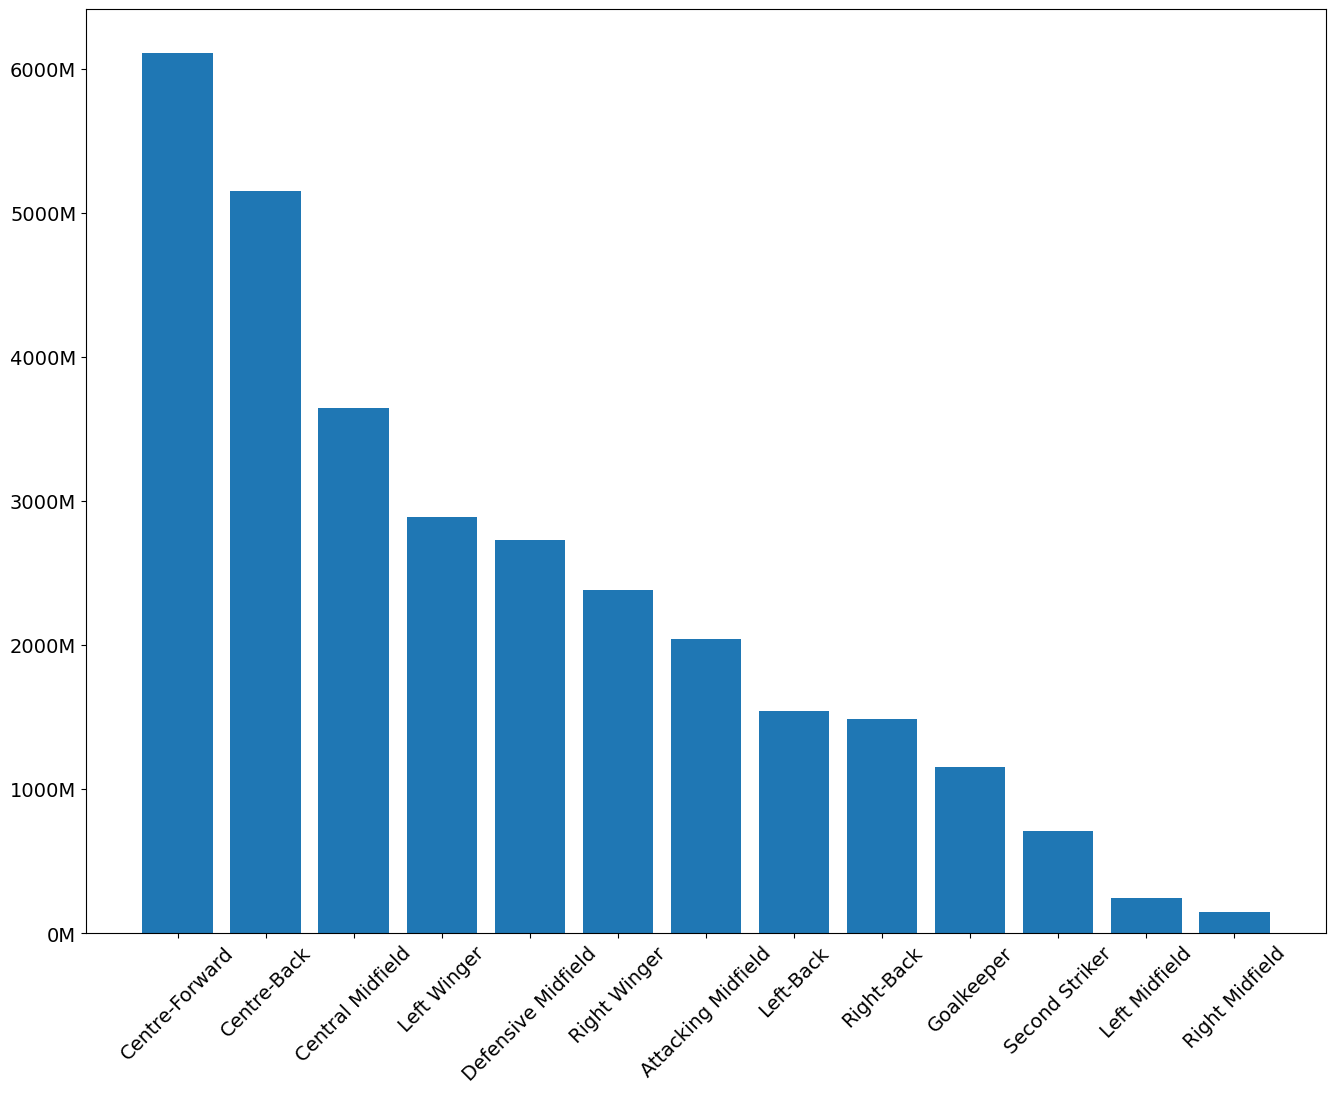

In [69]:
dic_pos = dict(sorted(dic_pos.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(16, 12))
plt.bar(dic_pos.keys(), [v[0] for v in dic_pos.values()])
plt.xticks(rotation=45, fontsize=14)  # Etiquetas del eje x
plt.yticks(fontsize=14)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))

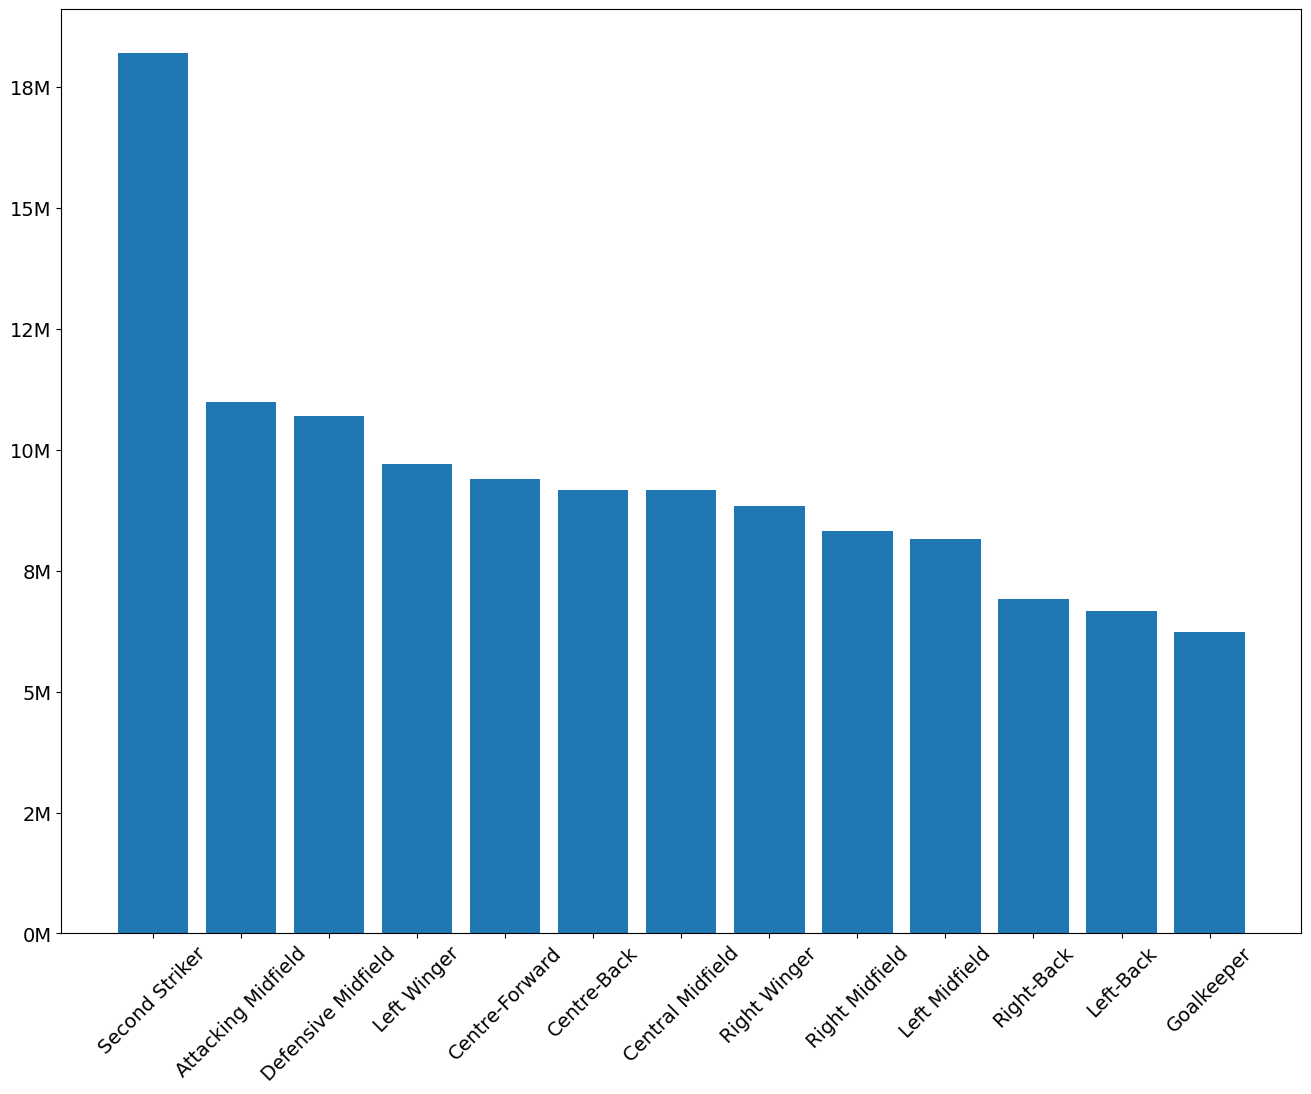

In [70]:
dic_pos = dict(sorted(dic_pos.items(), key=lambda item: item[1][0]/item[1][1], reverse=True))

plt.figure(figsize=(16, 12))
plt.bar(dic_pos.keys(), [round(v[0]/v[1], 2) for v in dic_pos.values()])
plt.xticks(rotation=45, fontsize=14)  # Etiquetas del eje x
plt.yticks(fontsize=14)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}M'))

In [93]:
gk.sort_values(by='Transfer_value').tail(12)

,Name,Exp_contr,Team_from,Team_to,Transfer_value,Position,Year,Age,Minutes_pl,Minutes_pl_LS,...,Yellow_cards,Red_cards,Country_from,Country_to,Save_perc,Save_perc_BC,Save_perc_LS,Save_perc_BC_LS,Reduced_from,Reduced_to
138,Robert Sánchez,23,Brighton,Chelsea,23000000,Goalkeeper,2023,25,8399,2280,...,5,1,Inglaterra,Inglaterra,0.68,0.68,0.63,0.59,Inglaterra,Inglaterra
124,Pau López,48,Real Betis,AS Roma,23500000,Goalkeeper,2019,24,6436,3150,...,7,0,España,Italia,0.70,0.70,0.65,0.65,España,Italia
117,Odisseas Vlachodimos,36,Nottm Forest,Newcastle,23600000,Goalkeeper,2024,30,8487,750,...,2,0,Inglaterra,Inglaterra,0.66,0.60,0.37,0.45,Inglaterra,Inglaterra
25,Edouard Mendy,33,Stade Rennais,Chelsea,24000000,Goalkeeper,2020,28,9683,2944,...,4,1,Francia,Inglaterra,0.74,0.73,0.70,0.76,Francia,Inglaterra
35,Filip Jörgensen,59,Villarreal,Chelsea,24500000,Goalkeeper,2024,22,4892,3330,...,6,0,España,Inglaterra,0.69,0.69,0.69,0.69,España,Inglaterra
115,Neto,24,Valencia,Barcelona,26000000,Goalkeeper,2019,30,8415,4230,...,4,0,España,España,0.76,0.77,0.75,0.76,España,España
41,Alex Meret,36,Udinese Calcio,Napoli,26000000,Goalkeeper,2019,22,5776,1780,...,0,1,Italia,Italia,0.78,0.77,0.78,0.81,Italia,Italia
1,Aaron Ramsdale,34,Sheff Utd,Arsenal,28000000,Goalkeeper,2021,23,9180,3780,...,1,0,Inglaterra,Inglaterra,0.62,0.68,0.69,0.69,Inglaterra,Inglaterra
50,Giorgi Mamardashvili,34,Valencia,Liverpool,30000000,Goalkeeper,2024,23,9000,3284,...,6,1,España,Inglaterra,0.71,0.71,0.72,0.72,España,Inglaterra
19,David Raya,12,Brentford,Arsenal,31900000,Goalkeeper,2024,28,9510,3720,...,3,0,Inglaterra,Inglaterra,0.73,0.73,0.66,0.66,Inglaterra,Inglaterra
